In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
from thingsvision import get_extractor
from thingsvision.utils.storing import save_features
from thingsvision.utils.data import ImageDataset, DataLoader
from thingsvision.core.extraction import center_features

# from google.colab import drive
from typing import Any, Dict, List

2 Physical GPUs, 2 Logical GPUs


In [2]:
full_image_path = '/home/yifan/projects/deepdebugertool/thingsvision/imgs/'
full_output_path = '/home/yifan/projects/deepdebugertool/thingsvision/features'
def extract_features(
                    extractor: Any,
                    module_name: str,
                    image_path: str,
                    out_path: str,
                    batch_size: int,
                    flatten_activations: bool,
                    apply_center_crop: bool,
                    class_names: List[str]=None,
                    file_names: List[str]=None,
) -> np.ndarray:
    """Extract features for a single layer."""                                    
    dataset = ImageDataset(
        root=image_path,
        out_path=out_path,
        backend=extractor.get_backend(),
        transforms=extractor.get_transformations(apply_center_crop=apply_center_crop, resize_dim=256, crop_dim=224),
        class_names=class_names,
        file_names=file_names,
    )
    batches = DataLoader(
        dataset=dataset, 
        batch_size=batch_size, 
        backend=extractor.get_backend(),
        )
    features = extractor.extract_features(
                    batches=batches,
                    module_name=module_name,
                    flatten_acts=flatten_activations,
    )
    return features


def extract_all_layers(
                        model_name: str,
                        extractor: Any,
                        image_path: str,
                        out_path: str,
                        batch_size: int,
                        flatten_activations: bool,
                        apply_center_crop: bool,
                        layer: Any=nn.Linear,
                        class_names: List[str]=None,
                        file_names: List[str]=None,
) -> Dict[str, np.ndarray]:
    """Extract features for all selected layers and save them to disk."""
    features_per_layer = {}
    for l, (module_name, module) in enumerate(extractor.model.named_modules(), start=1):
        if isinstance(module, layer):
            # extract features for layer "module_name"
            features = extract_features(
                                        extractor=extractor,
                                        module_name=module_name,
                                        image_path=image_path,
                                        out_path=out_path,
                                        batch_size=batch_size,
                                        flatten_activations=flatten_activations,
                                        apply_center_crop=apply_center_crop,
                                        class_names=class_names,
                                        file_names=file_names,
            )
            # replace with e.g., [f'conv_{l:02d}'] or [f'fc_{l:02d}']
            features_per_layer[f'layer_{l:02d}'] = features
            # save features to disk
            save_features(features, out_path=f'{out_path}/features_{model_name}_{module_name}', file_format='npy')
    return features_per_layer

In [32]:
pretrained = True # use pretrained model weights
model_path = '/home/yifan/dataset/clean/pairflip/cifar10/0/Model/Epoch_200/subject_model.pth' # if pretrained = False (i.e., randomly initialized weights) set path to model weights
tar_model_path = '/home/yifan/dataset/clean_ref/pairflip/cifar10/0/Model/Epoch_1/subject_model.pth'
batch_size = 32 # use a power of two (this can be any size, depending on the number of images for which you aim to extract features)
apply_center_crop = True # center crop images (set to False, if you don't want to center-crop images)
flatten_activations = True # whether or not features (e.g., of Conv layers) should be flattened
class_names = [ "bird", "car", "cat", "deer", "dog", "frog", "horse","plane", "ship", "truck"]  # optional list of class names for class dataset
file_names = None # optional list of file names according to which features should be sorted
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
GPU_ID = 0
# device = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")
device = 'cpu'

In [33]:
# load model
model_name = 'Resnet18_ecoset' 
# specify model source 
# we use torchvision here (https://pytorch.org/vision/stable/models.html)
source = 'custom'
model_parameters = {
    'model_path': model_path
}
# initialize the extractor
extractor = get_extractor( 
            model_name=model_name,
            pretrained=pretrained,
            model_path=model_path,
            device=device,
            model_parameters=model_parameters,
            source=source
)

2222 <module 'thingsvision.custom_models' from '/home/yifan/projects/deepdebugertool/thingsvision/thingsvision/custom_models/__init__.py'> Resnet18_ecoset


In [34]:
tar_model_parameters = {
    'model_path': tar_model_path
}
# initialize the extractor
tar_extractor = get_extractor( 
            model_name=model_name,
            pretrained=pretrained,
            model_path=tar_model_path,
            model_parameters=tar_model_parameters,
            device=device,
            source=source
)

2222 <module 'thingsvision.custom_models' from '/home/yifan/projects/deepdebugertool/thingsvision/thingsvision/custom_models/__init__.py'> Resnet18_ecoset


In [35]:
module_name = 'layer4.1.bn2' 

In [36]:
# extract features for a single layer (e.g., penultimate)
features = extract_features(
                            extractor=extractor,
                            module_name=module_name,
                            image_path=full_image_path,
                            out_path=full_output_path,
                            batch_size=batch_size,
                            flatten_activations=flatten_activations,
                            apply_center_crop=apply_center_crop,
                            class_names=class_names,
                            file_names=file_names,
)

# apply centering (not necessary, but may be desirable, depending on the analysis)
features = center_features(features)

# save features to disk
save_features(features, out_path=f'{full_output_path}/features_{model_name}_{module_name}', file_format='npy')


...Creating dataset.


Batch:   0%|          | 0/1 [00:00<?, ?it/s]

...Features successfully extracted for all 22 images in the database.
...Features shape: (22, 100352)
...Features successfully saved to disk.



In [43]:
# extract features for a single layer (e.g., penultimate)
tar_features = extract_features(
                            extractor=tar_extractor,
                            module_name=module_name,
                            image_path=full_image_path,
                            out_path=full_output_path,
                            batch_size=batch_size,
                            flatten_activations=flatten_activations,
                            apply_center_crop=apply_center_crop,
                            class_names=class_names,
                            file_names=file_names,
)

# apply centering (not necessary, but may be desirable, depending on the analysis)
tar_features = center_features(tar_features)

# save features to disk
save_features(features, out_path=f'{full_output_path}/tar_features_{model_name}_{module_name}', file_format='npy')


...Creating dataset.


Batch:   0%|          | 0/1 [00:00<?, ?it/s]

...Features successfully extracted for all 20 images in the database.
...Features shape: (20, 100352)
...Features successfully saved to disk.



In [38]:
from thingsvision.core.rsa import compute_rdm, plot_rdm,correlate_rdms

In [40]:
rdm = compute_rdm(features, method='correlation')

In [39]:
tar_rdm = compute_rdm(tar_features, method='correlation')

In [41]:
v = correlate_rdms(rdm_1=rdm,rdm_2=tar_rdm)
v

0.3769922928783579

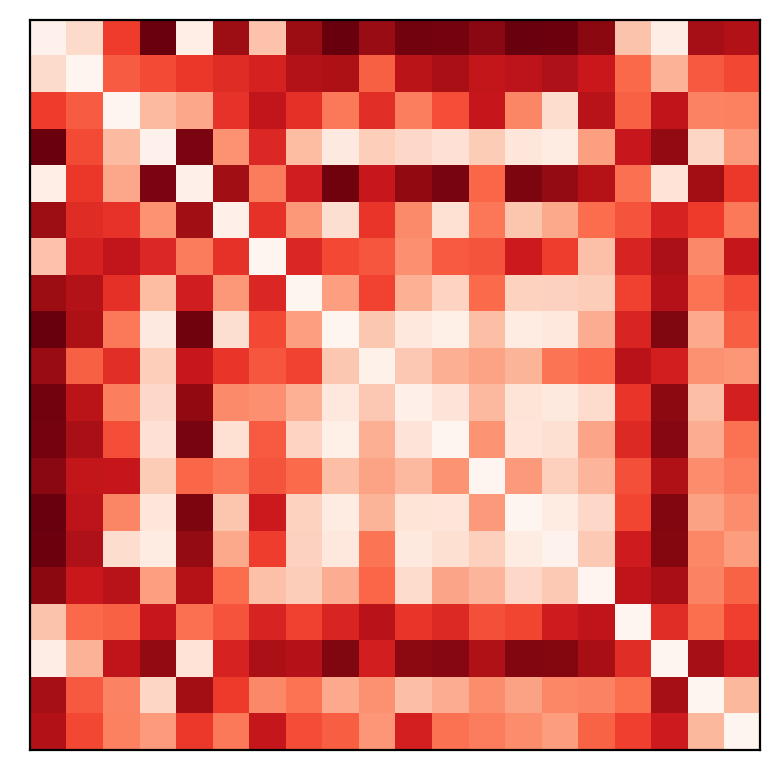

In [44]:
# plot rdm
plot_rdm(
        full_output_path,
        tar_features,
        method='correlation',
        format='.png', # '.jpg'
        colormap='Reds',
        show_plot=True,
        file_name = 'tar_rdm'
)

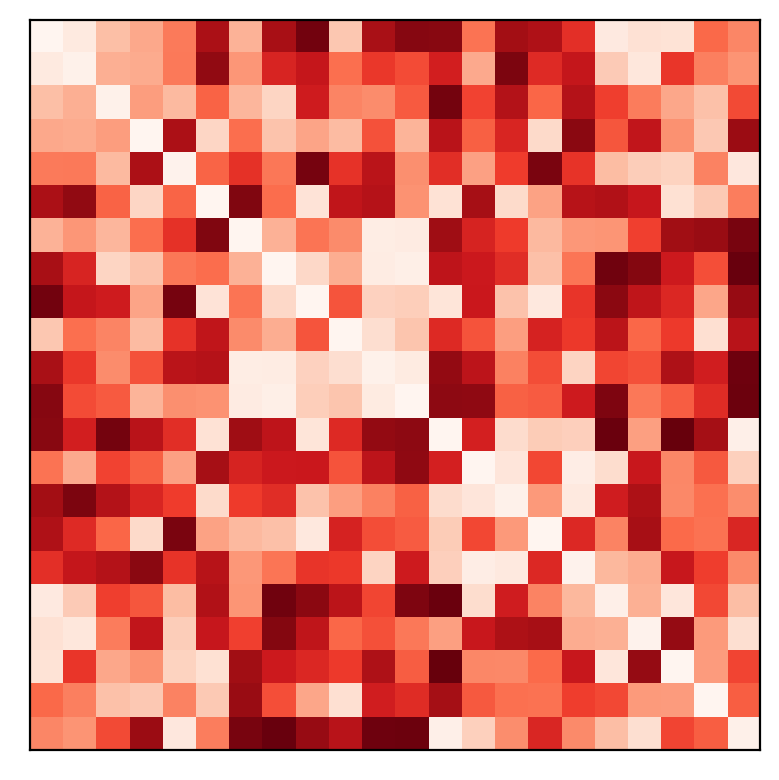

In [31]:
# plot rdm
plot_rdm(
        full_output_path,
        features,
        method='correlation',
        format='.png', # '.jpg'
        colormap='Reds',
        show_plot=True,
)